# Protein preparation and solvation pyCHARMM example.
## Retreive protein molecule from RCSB (PDB)
## Build protein molecule (may be multiple chains) minimize, visualize
## Solvate in a box of water using MMTSB Toolset
## Proteins already available for this tutorial are PTI (pancreatic trypsin inhibitor), PDBIDs: 4pti and 6pti and HDEA, a bacterial pH stress protein, that is a dimer (two identical chains), PDBID: 5wyo.

### Note we use some specific integration of processing to retreive information about segnames used by MMTSB in spltting files and preparing pdb, searching for SSBONDs, determining the number of chains. While these work in the test cases here, they may not work for all proteins in the pdb.

### Note that this notebook requires that you have the MMTSB Toolset available, that you start "pymol -R &" at the terminal window , and that the environment variable CHARMM_LIB_DIR are defined. (Note CHARMM_LIB_DIR should point to <charmm_install_path>/lib

# pyCHARMM header files plus some of the necessary functionality

In [1]:
# This script provides a simple example of building a
# protein and minimizing the structure and then
# calculating the energy to illustrate functionality to be
# exposed in pyCHARMM.
#  copyright C.L. Brooks III, June 1, 2022

# These are general python modules needed for this  tutorial
import os
import sys
import numpy as np

# These are a subset of the pycharmm modules that were installed when
# pycharmm was installed in your python environment
import pycharmm
import pycharmm.generate as gen
import pycharmm.ic as ic
import pycharmm.coor as coor
import pycharmm.energy as energy
import pycharmm.dynamics as dyn
import pycharmm.nbonds as nbonds
import pycharmm.minimize as minimize
import pycharmm.crystal as crystal
import pycharmm.image as image
import pycharmm.psf as psf
import pycharmm.read as read
import pycharmm.write as write
import pycharmm.settings as settings
import pycharmm.cons_harm as cons_harm
import pycharmm.cons_fix as cons_fix
import pycharmm.select as select
import pycharmm.shake as shake

from pycharmm.lib import charmm as libcharmm


## This little trick let's us view the structure with pymol provided we started pymol before using pymol -R &
### Open a terminal window in jupyter-lab and run $ pymol -R & before running the cell that follows.

In [2]:
# if you can run pymol in your setup issue the command above in the terminal and set the usepymol logical
# here:
usepymol = False
if usepymol:
    import xmlrpc.client as xmlrpclib
    cmd = xmlrpclib.ServerProxy('http://localhost:9123')
    cmd.reinitialize()
# Otherwise set usepymol to False and proceed.

## Since this is a protein, let's run mmtsb.pl -info to check how many chains, then gather info on SSBONDs and use convpdb.pl to get separate pdb files for each chain and finally display the structure in pymol, including cystein residues.

In [3]:
def get_assigned_segid(file=None):
    # read the pdb to get the assigned segid for each chain
    fpdb = open(file,'r')
    for l in fpdb:
        if l.split()[0] == 'ATOM':
            segid=l.strip().split()[-1]
            break
    fpdb.close()
    return segid

if usepymol: cmd.reinitialize()
pdbid = '4pti'  # bovine pancreatic trypsin inhibitor - an x-ray structuture
#pdbid = '6pti'  # bovine pancreatic trypsin inhibitor - an x-ray structuture
#pdbid = '5wyo'  # HDEA a dimeric (two chain) protein - an NMR structure
os.system('convpdb.pl -info {}.pdb > info'.format(pdbid))
os.system('grep SSBOND {}.pdb >> info'.format(pdbid))
fr = open('info', 'r')
chains = []
segids = []
disu = {}
for l in fr:
    if 'chains total' in l:
        nchains = l.split()[0]
    if l.split()[0]=='==':
        chains.append(l.split()[2])
    if l.split()[0]=='SSBOND':
        num = l.split()[1]
        res1 = l.split()[2]
        ch1 = l.split()[3]
        rn1 = l.split()[4]
        res2 = l.split()[5]
        ch2 = l.split()[6]
        rn2 = l.split()[7]
        disu[num] ={'residues':[res1,res2],
                    'chains':[ch1,ch2],
                    'resnums':[rn1,rn2]}
fr.close()
# Let's look at what was produced in the info file that we parsed
!cat info
os.system('rm info') # clean-up
# Check to see whether pdb directory needed below exists, if not, create it.
if not os.path.isdir('pdb'): os.system('mkdir pdb')
for chain in chains:
    # 5wyo is an NMR structure w/ multiple models, we can probably deduce that from the pdb automatically, but here
    # we just do it by hand, pick the first model.
    if pdbid == '5wyo': 
        os.system('convpdb.pl -out charmm22 -nsel {}: -model 1 -segnames {}.pdb > pdb/{}_{}.pdb'\
                                  .format(chain,pdbid,pdbid,chain.lower())) # Note .lower() to fix filenames
    else: 
        os.system('convpdb.pl -out charmm22 -nsel {} -segnames {}.pdb > pdb/{}_{}.pdb'\
                    .format('protein',pdbid,pdbid,chain.lower()))  # Note .lower() to fix filenames
    segids.append(get_assigned_segid(file='pdb/{}_{}.pdb'.format(pdbid,chain.lower())))
    if usepymol:
        # We can use this command interface to alter the view/representation and selection
        cmd.load('pdb/{}_{}.pdb'.format(pdbid,chain.lower()))
if usepymol and len(disu.keys())>0: cmd.show_as('sticks','resn CYS')

1 chains total
== chain A
1-58 101-160
xrange -2.202000 31.167000 : 33.369000
yrange 8.291000 35.796000 : 27.505000
zrange -9.863000 24.869000 : 34.732000
SSBOND   1 CYS A    5    CYS A   55                          1555   1555  2.05  
SSBOND   2 CYS A   14    CYS A   38                          1555   1555  2.09  
SSBOND   3 CYS A   30    CYS A   51                          1555   1555  2.02  


##  Read in the topology and parameter files
### The topology file contains the information pertinent to building molecular systems, either as independent molecules or as "residues" linked together to form more complex structures, i.e., proteins and nucleic acids. The parameter file contains the parameters that provide the information for the force field based calculations. CHARMM has topology and parameter files that are non-overlapping representations of different "regions" of chemical space, e.g., proteins ("_prot"), nucleic acids ("_na"), ethers, lipids, small drug-like molecules ("_cgenff"), etc. Here we will utilize the protein, water and ion topology and parameter files. These files are required to "generate" (see below) a psf that is necessary preceeding any molecular mechanics calculation.

In [4]:
# Read in the topology (rtf) and parameter file (prm) for proteins
# equivalent to the CHARMM scripting command: read rtf card name toppar/top_all36_prot.rtf
read.rtf('toppar/top_all36_prot.rtf')
# equivalent to the CHARMM scripting command: read param card flexible name toppar/par_all36m_prot.prm
read.prm('toppar/par_all36m_prot.prm', flex=True)

# stream in the water/ions parameter using the pycharmm.lingo module
# equivalent to the CHARMM scripting command: stream toppar/toppar_water_ions.str
pycharmm.lingo.charmm_script('stream toppar/toppar_water_ions.str')
# end toppar/toppar_water_ions.str


  
 CHARMM>     read rtf card -
 CHARMM>     name toppar/top_all36_prot.rtf
 VOPEN> Attempting to open::toppar/top_all36_prot.rtf::
 MAINIO> Residue topology file being read from unit  91.
 TITLE> *>>>>>>>>CHARMM36 ALL-HYDROGEN TOPOLOGY FILE FOR PROTEINS <<<<<<
 TITLE> *>>>>> INCLUDES PHI, PSI CROSS TERM MAP (CMAP) CORRECTION <<<<<<<
 TITLE> *>>>>>>>>>>>>>>>>>>>>>>>>>> MAY 2011 <<<<<<<<<<<<<<<<<<<<<<<<<<<<
 TITLE> * ALL COMMENTS TO THE CHARMM WEB SITE: WWW.CHARMM.ORG
 TITLE> *             PARAMETER SET DISCUSSION FORUM
 TITLE> *
 VCLOSE: Closing unit   91 with status "KEEP"
  
 CHARMM>     
  
  
 CHARMM>     read param card -
 CHARMM>     name toppar/par_all36m_prot.prm -
 CHARMM>     flex
 VOPEN> Attempting to open::toppar/par_all36m_prot.prm::

          PARAMETER FILE BEING READ FROM UNIT 91
 TITLE> *>>>> CHARMM36 ALL-HYDROGEN PARAMETER FILE FOR PROTEINS <<<<<<<<<<
 TITLE> *>>>>> INCLUDES PHI, PSI CROSS TERM MAP (CMAP) CORRECTION <<<<<<<<
 TITLE> *>>>>>>>>>>>>>>>>>>>>>>>>>> JAN. 20

1

## Specify the sequence of residues, generate them and build them.
### To do this we need to input the sequence of "residues" we wish to do calculations on, generate the particlar sequence with any blocking groups needed, here we will terminate the sequence with an acetyl N-terminal "patch" and an N-methyl amide C-terminal "patch". Note we will use the segids just collected to construct the "segment" of structure for generation of the psf data structures in CHARMM we will setup the ic (internal coordinate) tables that will allow us to build the missing atoms in the structure from the known bond distances, angles and dihedrals.

In [5]:
# Loop over the segments identified in the pdb files
for ichain,segid in enumerate(segids):
    # read in the sequence of the protein to be generated
    # only useful for the same residue
    # equivalent to the CHARMM scripting command:
    # read sequ pdb name pdb/{}_{}.pdb
    read.sequence_pdb('pdb/{}_{}.pdb'.format(pdbid,chains[ichain].lower())) # Note .lower() to fix filenames

    # equivalent to the CHARMM scripting command: generate ADP first ACE last CT3 setup
    gen.new_segment(seg_name=segid, first_patch='ACE', last_patch='CT3', setup_ic=True)
    # equivalent to read coor pdb name pdb/{}_{}.pdb resid
    read.pdb('pdb/{}_{}.pdb'.format(pdbid,chains[ichain].lower()),resid=True) # Note .lower() to fix filenames
    # equivalent to the CHARMM scripting command: ic param
    ic.prm_fill(replace_all=False)
    # equivalent to the CHARMM scripting command: ic build
    ic.build()
# add disulfide bonds in present
# note, we do this after we generate the sequences since there may be inter-chain disulfides
if len(disu.keys())>0:
    for ssbond in disu.keys():
        pycharmm.lingo.charmm_script('patch disu pro{} {} pro{} {}'\
                                     .format(disu[ssbond]['chains'][0],disu[ssbond]['resnums'][0],
                                             disu[ssbond]['chains'][1],disu[ssbond]['resnums'][1]))
# The coor orie command is useful to expose since it allows one to
# orient the system in preparation for other calculations
# equivalent to the CHARMM scripting command: coor orient
coor.orient(by_rms=False,by_mass=False,by_noro=False)
# equivalent to the CHARMM scripting command: print coor
coor.show()
# If pdb directory doesn't already exist make it here.
if not os.path.isdir('pdb'): os.system('mkdir pdb')
# equivalent to the CHARMM scripting command: write coor pdb name pdb/pdbid_initial.pdb
write.coor_pdb('pdb/{}_initial.pdb'.format(pdbid))

  
 CHARMM>     read sequence pdb -
 CHARMM>     name pdb/4pti_a.pdb
 VOPEN> Attempting to open::pdb/4pti_a.pdb::
 MAINIO> Sequence information being read from unit  91.
 TITLE>  *

          RESIDUE SEQUENCE --    58 RESIDUES
          ARG PRO ASP PHE CYS LEU GLU PRO PRO TYR THR GLY PRO CYS LYS ALA ARG ILE ILE ARG 
          TYR PHE TYR ASN ALA LYS ALA GLY LEU CYS GLN THR PHE VAL TYR GLY GLY CYS ARG ALA 
          LYS ARG ASN ASN PHE LYS SER ALA GLU ASP CYS MET ARG THR CYS GLY GLY ALA 
 ***** Message from SEQRDR ***** THE SYSTEM CONTAINS 12 TITRATABLE GROUPS
 THE USER MUST PREDETERMINE THE PROTONATION STATE THROUGH THE SEQUENCE AND RTF
 HIS -  0  HSD -  0  HSE -  0  HSP -  0  ASP -  2  GLU -  2  LYS -  4  TYR -  4
 VCLOSE: Closing unit   91 with status "KEEP"
  
 CHARMM>     
  
 THE PATCH 'ACE' WILL BE USED FOR THE FIRST RESIDUE
 THE PATCH 'CT3' WILL BE USED FOR THE LAST  RESIDUE
 GENPSF> Segment   1 has been generated. Its identifier is PROA.
 PSFSUM> PSF modified: NONBOND lists and

## Visualize our initial structure to make sure it looks reasonable.

In [6]:
# Visuaize the initial structure
if usepymol:
    cmd.reinitialize()
    # We can use this command interface to alter the view/representation and selection
    cmd.load('pdb/{}_initial.pdb'.format(pdbid))
    if len(disu.keys())>0: cmd.show_as('sticks','resn CYS') # highlight cysteines

## Now lets minimize the structure and view the minimized structure in pymol
### To do this we will first specify the non-bonded parameters we want to use for these molecular mechanics calculations. Note we are spcifying that we will use the fswitch and vfswitch force-switching functions to truncate the electrostatic and vdW interactions. The switching will occur between ctonnb and ctofnb. We will build a non-bonded list to process pairs of interacting atoms using a cutoff radius of cutnb. We will use atom-based electrostatic (atom) and vdW (vatom) non-bonded list generaton schemes and will repreent the Coulomb electrostatic interactions with a constant dielectric constant (versus an r-dependent dielectric constant) of 1 (cdie=1.0). There are multiple ways of inputting the nonbonded parameters, here we create a python object my_nbonds which has a .run() attribute. 
### We set harmonic restraints on the CA atoms and allow the backbone to relax.
### Next we will use CHARMM's sd (steepest descents) minimizer to minimize the structure we just built using the non-bonded methods we just specified. The minimizer is set-up to run 300 steps of minimization unless the energy change falls below 0.001 or the gradient of the energy falls below 0.001, in which case minimization will stop. The purpose is to just get any "vdW bumps" cleaned-up and bond lengths/angles adjusted to our potential function. Finally we print out the final energy.

In [7]:
# Specify nonbonded python object called my_nbonds - this just sets it up
# equivalant CHARMM scripting command: nbonds cutnb 18 ctonnb 13 ctofnb 17 cdie eps 1 atom vatom fswitch vfswitch
my_nbonds = pycharmm.NonBondedScript(
    cutnb=18.0, ctonnb=13.0, ctofnb=17.0,
    eps=1.0,
    cdie=True,
    atom=True, vatom=True,
    fswitch=True, vfswitch=True)

# Implement these non-bonded parameters by "running" them.
my_nbonds.run()
# equivalent to: cons harm force 20 select type ca end
cons_harm.setup_absolute(selection=pycharmm.SelectAtoms(atom_type='CA'),force_constant=20)
# equivalent CHARMM scripting command: minimize abnr nstep 1000 tole 1e-3 tolgr 1e-3
minimize.run_sd(nstep=300, tolenr=1e-3, tolgrd=1e-3)
# equivalent CHARMM scripting command: energy
energy.show()
# equivalent to the CHARMM scripting command: write coor pdb name pdb/initial.pdb
write.coor_pdb('pdb/{}_minimized.pdb'.format(pdbid))
write.psf_card('pdb/{}.psf'.format(pdbid))

  
 CHARMM>     nbonds cutnb 18.0 -
 CHARMM>     ctonnb 13.0 -
 CHARMM>     ctofnb 17.0 -
 CHARMM>     eps 1.0 -
 CHARMM>     cdie -
 CHARMM>     atom -
 CHARMM>     vatom -
 CHARMM>     fswitch -
 CHARMM>     vfswitch

 NONBOND OPTION FLAGS: 
     ELEC     VDW      ATOMs    CDIElec  FSWItch  VATOm    VFSWIt  
     BYGRoup  NOEXtnd  NOEWald 
 CUTNB  = 18.000 CTEXNB =999.000 CTONNB = 13.000 CTOFNB = 17.000
 CGONNB =  0.000 CGOFNB = 10.000
 WMIN   =  1.500 WRNMXD =  0.500 E14FAC =  1.000 EPS    =  1.000
 NBXMOD =      5
 There are        0 atom  pairs and        0 atom  exclusions.
 There are        0 group pairs and        0 group exclusions.
 <MAKINB> with mode   5 found   2556 exclusions and   2364 interactions(1-4)
 <MAKGRP> found    826 group exclusions.
 Generating nonbond list with Exclusion mode = 5
 == PRIMARY == SPACE FOR   405451 ATOM PAIRS AND        0 GROUP PAIRS

 General atom nonbond list generation found:
   285472 ATOM PAIRS WERE FOUND FOR ATOM LIST
     5837 GROUP PAIRS

## Visually compare the minimized and initial structure? Do they look different?

In [8]:
# This import enables pymol command interpreter to be used
if usepymol:
    # We can use this command interface to alter the view/representation and selection
    cmd.load('pdb/{}_minimized.pdb'.format(pdbid))
    if len(disu.keys())>0: cmd.show_as('sticks','resn CYS')

# Solvate the protein in TIP3P water
## In the following we will use the MMTSB toolset to solvate the blocked alanine residue in a cubic box of TIP3P water using the convpdb.pl commands noted below.

## First we figure out whether we need to add counter ions to neutralize the overall charge.

In [9]:
import numpy as np
# find the overall charge so we can add neutralizing ions
q = psf.get_charges()
Ntot = round((np.sum(q)))
if Ntot > 0: ion_type = 'CLA'
if Ntot < 0: ion_type = 'SOD'
ions = '-ions {}:{}'.format(ion_type,np.abs(Ntot))
if np.abs(Ntot) < 1e-2: ions = ''

In [10]:
# CHARMM scripting command: system "convpdb.pl -solvate {ions} -cutoff 10 -cubic -out charmm22 pdb/adp.pdb
# | convpdb.pl -segnames -nsel TIP3 > pdb/{}_wt00.pdb"
solvate_command = 'convpdb.pl -solvate -cutoff 10 {} -cubic -out charmm22 pdb/{}_minimized.pdb > pdb/w.pdb;'\
    .format(ions,pdbid)
solvate_command +='convpdb.pl -segnames -nsel TIP3 pdb/w.pdb > pdb/{}_wt00.pdb;'.format(pdbid)
solvate_command +='convpdb.pl -segnames -nsel ion pdb/w.pdb > pdb/ions.pdb'
# run the command as a system subprocess
os.system(solvate_command)
# replace HETATM by ATOM in ions
fpdb = open('pdb/ions.pdb','r')
opdb = open('pdb/{}_ions.pdb'.format(pdbid),'w')
for l in fpdb:
    print(l.strip().replace('HETATM','ATOM  '),file=opdb)
fpdb.close()
opdb.close()
# clean-up non-specific files
os.system('rm pdb/ions.pdb')

read 648 atoms, 216 residues from /export/apps/CentOS7/mmtsb/src/feig/toolset//data/water.pdb
read 901 atoms, 58 residues from -
box size: 63.774018 x 63.774018 x 63.774018


0

In [11]:
if usepymol: 
    cmd.reinitialize()
    cmd.load('pdb/{}_minimized.pdb'.format(pdbid))
    cmd.load('pdb/{}_wt00.pdb'.format(pdbid))
    cmd.load('pdb/{}_ions.pdb'.format(pdbid))
    cmd.show_as('spheres','name {}'.format(ion_type))
    cmd.color('red','name {}'.format(ion_type))

### Generate water segment and minimize the system, protein + solvent + ions, finally save the psf and coordinates
### Note that in "conditioning" the system I first fix the protein atoms and then minimize the water. I am using the steepest descents algorithm because it works best for large systems and/or when you may have bad contacts.

1) **build the water and ion segments**

In [12]:
# Here is an alternative means of reading a sequence
# read sequ pdb name pdb/{}_wt00.pdb
# get the water segid:
water_segment = get_assigned_segid(file='pdb/{}_wt00.pdb'.format(pdbid))
# Let's set the wrnlev to 0 to avoid the large output
old_wrnlev = settings.set_warn_level(0)
read.sequence_pdb('pdb/{}_wt00.pdb'.format(pdbid))
# Now reset back to default wrnlev
settings.set_warn_level(old_wrnlev)
# Another example of the generate command
# generate wt00 noangle nodihedral
gen.new_segment(water_segment, angle=False, dihedral=False)

# read coor pdb name pdb/pdbid_wt00.pdb resid
read.pdb('pdb/{}_wt00.pdb'.format(pdbid), resid=True)

# Here is an alternative means of reading a sequence
# read sequ pdb name pdb/{}_ions.pdb
# get ion sequence name
ion_segment = get_assigned_segid(file='pdb/{}_ions.pdb'.format(pdbid))
read.sequence_pdb('pdb/{}_ions.pdb'.format(pdbid))

# Another example of the generate command
# generate wt00 noangle nodihedral
gen.new_segment(ion_segment, angle=False, dihedral=False)

# read coor pdb name pdb/adp.pdb resid
read.pdb('pdb/{}_ions.pdb'.format(pdbid), resid=True)
# get the coor statistics to construct boxlengths
# coor stat
stats = coor.stat()

  
 CHARMM>     read sequence pdb -
 CHARMM>     name pdb/4pti_wt00.pdb
 VOPEN> Attempting to open::pdb/4pti_wt00.pdb::
 MAINIO> Sequence information being read from unit  91.
 TITLE>  *

          RESIDUE SEQUENCE --  7911 RESIDUES
          TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3
          TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3
          TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3
          TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3
          TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3
          TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3
          TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3
          TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3
          TIP3TIP3TIP3TIP3TIP3TIP3TIP3T

2) **Figure out the boxsize**
3) **add periodic boundary conditions**
4) **minimize**
5) **write psf and final minimized coordinates, ready for simulations**

In [13]:
# boxsize
xsize = stats['xmax'] - stats['xmin']
ysize = stats['ymax'] - stats['ymin']
zsize = stats['zmax'] - stats['zmin']
boxsize = max(xsize, ysize, zsize)

# half box size
boxhalf = boxsize / 2.0

# CHARMM scripting: crystal define cubic @boxsize @boxsize @boxsize 90 90 90
crystal.define_cubic(boxsize)
# CHARMM scripting: crystal build cutoff @boxhalf noper 0
crystal.build(boxhalf)

# Turn on image centering - bysegment for protein, by residue for solvent and ions
# CHARMM scripting: image byseg xcen 0 ycen 0 zcen 0 select segid SEGID end
for segid in segids:
    image.setup_segment(0.0, 0.0, 0.0, segid)
# CHARMM scripting: image byres xcen 0 ycen 0 zcen 0 select resname tip3 end
image.setup_residue(0.0, 0.0, 0.0, 'TIP3')
# CHARMM scripting: image byres xcen 0 ycen 0 zcen 0 select resname ion_type end
image.setup_residue(0.0, 0.0, 0.0, ion_type)

# Now specify nonbonded cutoffs for solvated box
cutnb = min(boxhalf,12)
cutim = cutnb
ctofnb = cutnb - 1.0
ctonnb = cutnb - 3.0

# Another nbonds example
# CHARMM scripting: nbonds cutnb @cutnb cutim @cutim ctofnb @ctofnb ctonnb @ctonnb -
#        inbfrq -1 imgfrq -1
pycharmm.NonBondedScript(
    cutnb=cutnb, cutim=cutim, ctonnb=ctonnb, ctofnb=ctofnb,
    eps=1.0,
    cdie=True,
    atom=True, vatom=True,
    fswitch=True, vfswitch=True,
    inbfrq=-1, imgfrq=-1).run()

# Fix the peptide and minimize the solvent to "fit"
# CHARMM scripting: cons fix select segid adp end
cons_fix.setup(pycharmm.SelectAtoms(seg_id=segids))

# Minimize the solvent positions with periodic boundary conditions using steepest descents
# CHARMM scripting: mini sd nstep 200 tole 1e-3 tolgrd 1e-3
minimize.run_sd(nstep=200, tolenr=1e-3, tolgrd=1e-3)

# Turn off fixed atoms
# CHARMM scripting: cons fix select none end
cons_fix.turn_off()

# Write the psf and coordinates for the solvated peptide
# write psf card name pdb/adp+wat.psf
write.psf_card('pdb/{}+wat.psf'.format(pdbid))
# write coor pdb name pdb/adp+wat_min.pdb
write.coor_pdb('pdb/{}+wat_min.pdb'.format(pdbid))

 Crystal Parameters : Crystal Type = CUBI
           A     =   64.89100 B    =   64.89100 C     =   64.89100
           Alpha =   90.00000 Beta =   90.00000 Gamma =   90.00000
 XBUILD> Building all transformations with a minimum atom-atom
         contact distance of less than   32.45 Angstroms.

 Range of Grid Search for Transformation     1 :
 Lattice Vector A    -2 TO     2
 Lattice Vector B    -2 TO     2
 Lattice Vector C    -2 TO     2


 The number of transformations generated =    26


 Number  Symop   A   B   C   Distance

      1      1  -1  -1  -1     8.0036
      2      1  -1   0  -1     5.5414
      3      1  -1   1  -1     7.1975
      4      1   0  -1  -1     5.9875
      5      1   0   0  -1     3.1059
      6      1   0   1  -1     4.5119
      7      1  -1  -1   0     4.4087
      8      1  -1   0   0     3.7024
      9      1  -1   1   0     4.6365
     10      1   0  -1   0     2.8685
     11      1   0   1   0     2.8685
     12      1  -1  -1   1     6.8840
     1

## Finally, let's visualize the system and see what things look like!

In [ ]:
if usepymol:
    cmd.reinitialize()
    cmd.load('pdb/{}+wat_min.pdb'.format(pdbid))
    cmd.show_as('spheres','resn {}'.format(ion_type))
    cmd.color('red','resn {}'.format(ion_type))

# This is the end of this tutorial example. 
## You should have learned how to 1) build a multi-segment protein with disulfide bonds; 2) to minimize the system and examine the results of the minimization; 3) to use the MMTSB Toolset to solvate and neutralize the system (with convpdb.pl); 4) to prepare the solvated system for further calculations by "conditioning" the solvent after the solvent overlay.
## As an exercise, try modifying this tutorial to build your favorite protein. Use the same blocking groups.

### Other things to consider are:
1) How do we choose protonation state for fixed protonation state models?
* use knowledge of pKas of titratable residues in protein of interest
* use a tool like PropKa to assign appropriate protonation state for titratable residues
2) How do we add a specific ionic strength of excess salt?

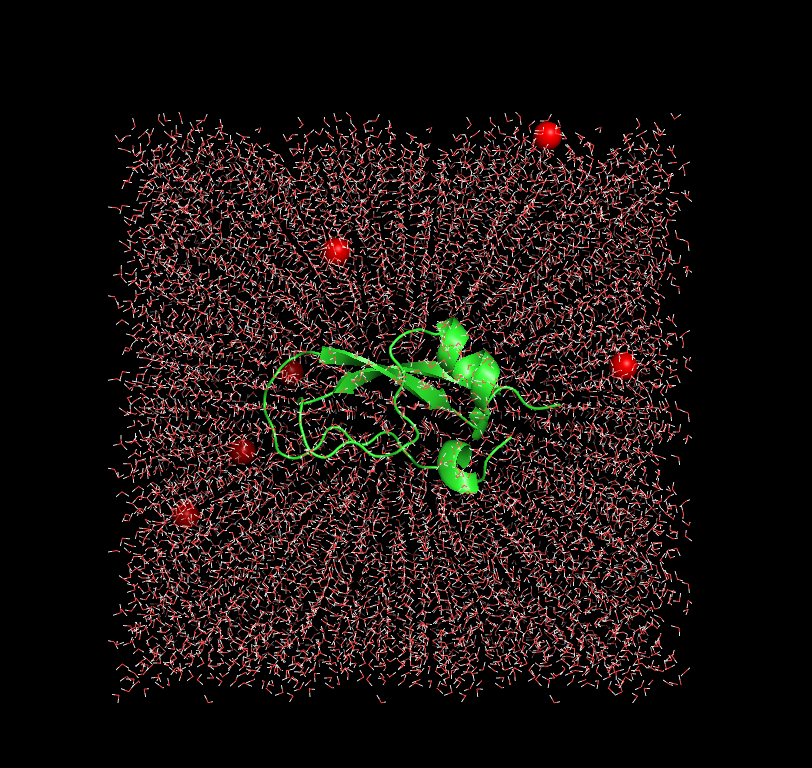